## Regression Models

Since my goal is to predict a video CTR based on its title, I want to explore to what extent I can achieve an exact CTR prediction instead of categorizing the CTR on a scale from low to high. To accomplish this, I will train a vanilla Random Forest Regressor with the data I used to train my vanilla classifier models (using TF-IDF):

In [1]:
#Import libraries   

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
import nltk.corpus
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string
import os
import regex as re


from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, f1_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

import gensim
import gensim.downloader as api
from gensim.models import Doc2Vec, Word2Vec, KeyedVectors
from gensim.models.doc2vec import TaggedDocument
from gensim.test.utils import datapath
import xgboost as xgb

from adjustText import adjust_text

from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

from capstone_functions import evaluate_model, compare_models, preprocess_title

import warnings
warnings.filterwarnings("ignore")

seed=293

In [2]:
#Import pre-processed DataFrames
df = pd.read_csv('final.csv')
df2 = df.copy()

In [3]:
#Slice the DataFrame using just features and target
df2 = pd.read_csv('data/finalized/main_dataset.csv')
df2 = df2[['video_title','ctr']]

In [4]:
#Pre-process the titles as I did in my EDA notebook, but skip tokenization
df2.video_title = df2.video_title.apply(lambda x: preprocess_title(x, tokenize=False))

In [5]:
#Create a pipeline with the vectorizer and the Random Forest Regressor
regr_pipeline = Pipeline(steps=[("ttf-idf", TfidfVectorizer(decode_error='ignore'
                                             )),
                  ("model", RandomForestRegressor(n_estimators=10))
                ])

In [6]:
# Split data into training and test sets
X = df2['video_title']
y = df2['ctr']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=seed)


In [7]:
#Fit the trainig data
regr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('ttf-idf', TfidfVectorizer(decode_error='ignore')),
                ('model', RandomForestRegressor(n_estimators=10))])

In [8]:
#Get predictions
y_pred = regr_pipeline.predict(X_test)

In [9]:
y_pred

array([2.764     , 7.196     , 6.626     , ..., 3.833     , 1.669     ,
       7.45266667])

In [10]:
#Calculate the RMSE 
mse = mean_squared_error(y_test,y_pred)

rmse = np.sqrt(mse)
rmse

3.512438488905239

This model can predict the exact CTR with a margin of error of about 3.5%. This is about twice the std in CTR we saw across all channels. Doesn't seem precise enough. Let's see if I can do better.

# Word2Vec

I want to explore another NLP technique, representing words with vectors. In addition, I'm curious to see if representing entire titles with their own vectors will improve my models' performance.

In [11]:
#Let's reload the data and reassign CTR range categories, this time based on smaller brackets
df = pd.read_csv('data/finalized/main_dataset.csv')
df.head(3)

def ctr_range(df):
    if df['ctr'] < 1.00:
        return 'Under 1%'
    elif 1.00 < df['ctr'] < 3.00:
        return 'Between 2-3%'
    elif 3.00 < df['ctr'] < 5.00:
        return 'Between 3-5%'
    elif 5.00 < df['ctr'] < 8.00:
        return 'Between 5-8%'
    elif df['ctr'] > 8:
        return 'Over 8%'
    else:
        return 'Undefined'

#Add the class to each video in the DataFrame
df['ctr_range'] = df.apply(ctr_range, axis=1)

In [12]:
df = df[['video_title','ctr', 'ctr_range']]

df.video_title = df.video_title.apply(preprocess_title)

df.head(3)

,video_title,ctr,ctr_range
0,hitting on female cops,10.07,Over 8%
1,naked guy picking up girls,5.75,Between 5-8%
2,flirting with very nice american female office...,11.23,Over 8%


In [13]:
def tokenize_text(text):
    """
    Input: takes a string
    
    Output: a list of tokens using NLTK's tokenizer
    """
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

In [14]:
#Before I tokenize the titles, I'll do my train test split 
train, test = train_test_split(df, test_size=0.2, random_state=seed)

In [15]:
#Now, let's tag every title with the appropriate CTR range
train_tagged = train.apply(lambda r: TaggedDocument(words=tokenize_text(r['video_title']), tags=[r.ctr_range]), axis=1)
test_tagged = test.apply(lambda r: TaggedDocument(words=tokenize_text(r['video_title']), tags=[r.ctr_range]), axis=1)

In [16]:
#Let's instantiate a doc2vec model, in this case in ignores words with frequency lower than 2
model = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0)

model.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 7528/7528 [00:00<00:00, 3240426.98it/s]


Out of curiosity, I want to run a quick classifier with Logistic Regression and see if Word2Vec shows a noticeably higher accuracy.

In [17]:
def vec_for_learning(model, tagged_docs):
    """
    This function prepares the data for the classfier.
    """
    sents = tagged_docs.values
    targets, features = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, features

In [18]:
#Assign the appropriate targets and features to the train and test sets
y_train, X_train = vec_for_learning(model, train_tagged)
y_test, X_test = vec_for_learning(model, test_tagged)

#Fit the model and make predictions
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))

Testing accuracy 0.25292242295430395


Okay, YIKES!

Next, I'll map entire titles as vectors and proceed with my regression model improvements. 

To do so, I need preprocess the titles once again and keept them intact. To make this process a bit easier, I found and borrowed a few functions from GitHub user Dimitris Spathis, [credit goes to him!](https://github.com/sdimi/average-word2vec) 

In [19]:
def document_vector(word2vec_model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in model.vocab]
    return np.mean(model[doc], axis=0)

def preprocess(text):
    text = text.lower()
    doc = word_tokenize(text)
    doc = [word for word in doc if word not in stop_words]
    doc = [word for word in doc if word.isalpha()] 
    return doc

# Function that will help us drop documents that have no word vectors in word2vec
def has_vector_representation(word2vec_model, doc):
    """check if at least one word of the document is in the
    word2vec dictionary"""
    return not all(word not in word2vec_model.vocab for word in doc)

# Filter out documents
def filter_docs(corpus, texts, condition_on_doc):
    """
    Filter corpus and texts given the function condition_on_doc which takes a doc.
    The document doc is kept if condition_on_doc(doc) is true.
    """
    number_of_docs = len(corpus)

    if texts is not None:
        texts = [text for (text, doc) in zip(texts, corpus)
                 if condition_on_doc(doc)]

    corpus = [doc for doc in corpus if condition_on_doc(doc)]

    print("{} docs removed".format(number_of_docs - len(corpus)))

    return (corpus, texts)

In [20]:
#One of the functions requires the stopwrods list 
stop_words = stopwords.words('english')

In [21]:
#Let's prepare the corpus with all titles
video_titles = df.video_title

corpus = [preprocess(title) for title in video_titles]

In [22]:
#preview the result of the pre-processed titles
corpus[:3]

[['hitting', 'female', 'cops'],
 ['naked', 'guy', 'picking', 'girls'],
 ['flirting', 'nice', 'american', 'female', 'officer', 'norwegian']]

In [23]:
# Remove empty docs
corpus, video_titles = filter_docs(corpus, video_titles, lambda doc: (len(doc) != 0))

5 docs removed


In [24]:
from gensim.models import KeyedVectors
from gensim.test.utils import datapath

#Let's load another word2vec model 
model = KeyedVectors.load_word2vec_format(datapath('word2vec_pre_kv_c'), binary=False)

In [25]:
# Remove docs that don't include any words in W2V's vocab
corpus, video_titles = filter_docs(corpus, video_titles, lambda doc: has_vector_representation(model, doc))

2552 docs removed


In [26]:
# Filter out any empty docs
corpus, video_titles = filter_docs(corpus, video_titles, lambda doc: (len(doc) != 0))

x = []
for doc in corpus: # append the vector for each document
    x.append(document_vector(model, doc))
    
X = np.array(x) # list to array

0 docs removed


In [27]:
#Let's import and use PCA for dimension reduction
from sklearn.decomposition import PCA
twodim =  PCA().fit_transform(X)[:,:2]

In [28]:
# Adding ability to match presentation colors with graph colors
enmax_palette = ["#ff9999", "#001a29"]
color_codes_wanted = ['background', 'tactiq']

c = lambda x: enmax_palette[color_codes_wanted.index(x)]

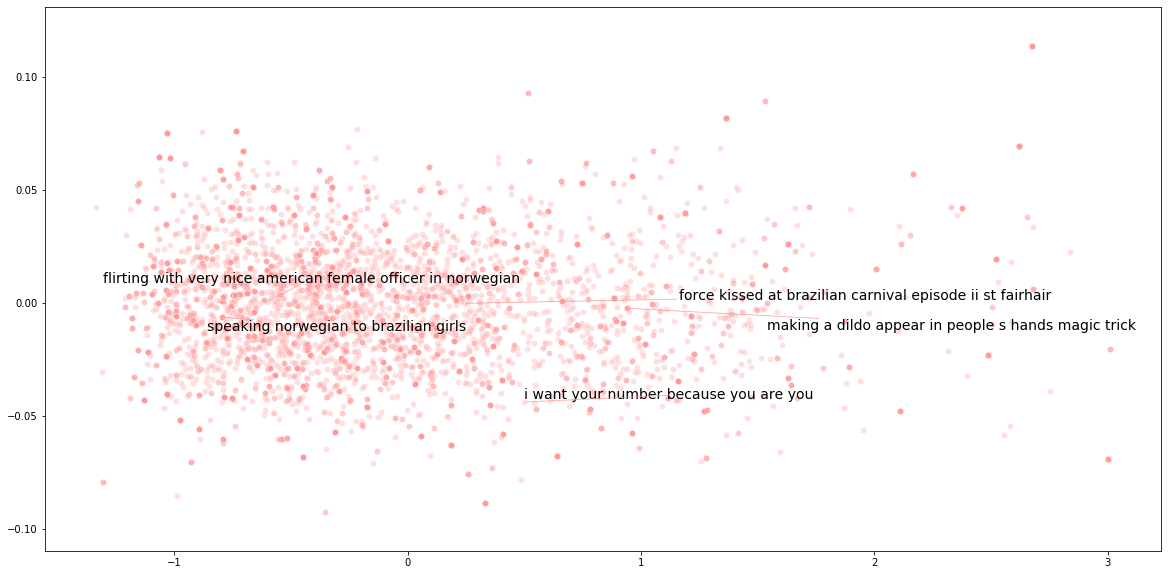

In [29]:
#Let's create a scatter plot where each dot represents a title, and explore their similarity

sns.set_palette(sns.color_palette(enmax_palette))

fig, ax = plt.subplots(figsize = (20, 10))
sns.scatterplot(twodim[:, 0], twodim[:, 1], alpha = 0.3)

from adjustText import adjust_text
texts = []
titles_to_plot = list(np.arange(0, 100, 20)) # plots every 40th title in first 400 titles

# Append words to list
for title in titles_to_plot:
    texts.append(plt.text(twodim[title, 0], twodim[title, 1], video_titles[title], fontsize = 14))
    
# Plot text using adjust_text
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = c('background'), lw = 0.7))

plt.show()

Seems like everything worked well. Similir titles appear close together.

In [30]:
#Let's merge the PCA representation of the vectors with the titles
df_w_vectors = pd.DataFrame(twodim)

df_w_vectors['video_title'] = video_titles

# Use pd.concat to match original titles with their vectors
main_w_vectors = pd.concat((df_w_vectors, df), axis=1)


In [32]:
#Preview
df_w_vectors.head(3)

,0,1,video_title
0,-0.603611,0.000639,flirting with very nice american female office...
1,0.118238,0.034758,back at the carnival brazil trip
2,1.627639,0.026269,awkwardly asking girls out for valentine s day


In [33]:
#Let's merge back into the main DataFrame
main_df = df.merge(df_w_vectors, on="video_title", how="left")

In [34]:
#Preview
main_df.head()

,video_title,ctr,ctr_range,0,1
0,hitting on female cops,10.07,Over 8%,NaN,NaN
1,naked guy picking up girls,5.75,Between 5-8%,NaN,NaN
2,flirting with very nice american female office...,11.23,Over 8%,-0.603611,0.000639
3,naked guy picking up girls in usa,4.68,Between 3-5%,NaN,NaN
4,edgard tries to sell me to this brazilian girl,3.86,Between 3-5%,NaN,NaN


In [35]:
#Some titles didn't have a vector representation and we duplicated when I merged the DataFrames, let's drop them
main_df.dropna(inplace=True)

In [36]:
#Let's reassign the features and the target variable
X_2 = main_df.drop(columns=['ctr_range','ctr','video_title'])
y_2 = main_df.ctr

In [37]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(X_2, y_2, test_size = 0.2, random_state = seed)

Before I run the Random Forest Regressor again, I want to see if one of the most powerful algorithms will perform well with this newlt formatted titles - XGBoost.

In [38]:
# Instantiate an XGBRegressor
xgr = xgb.XGBRegressor(random_state=seed)

# Fit the classifier to the training set
xgr.fit(X_train, y_train)

#Make Predictions
y_pred = xgr.predict(X_test)

#Measure 
mse2 = mean_squared_error(y_test, y_pred)
rmse2 = np.sqrt(mse2)
rmse2

[21:31:14] WARNING: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


3.437732592020468

A slight improvement, from 3.512% on the vanilla Random Forrest to 3.43% on XGB.

Let's run Random Forrest again on vectorized titles:

In [39]:
rfrg = RandomForestRegressor()

In [40]:
rfrg.fit(X_train, y_train)

RandomForestRegressor()

In [41]:
y_pred_2 = rfrg.predict(X_test)

In [42]:
mse = mean_squared_error(y_test,y_pred_2)

rmse = np.sqrt(mse)
rmse

3.5040227863379823

A minimal improvement from 3.512% to 3.5%. Still, when it comes to exact prediction of the CTR, XGB is doing a better job. Neither is prceise enough, so let's go back to classifiers.